# Meteorological data processing
To create the main input file for a environmental profile/tracking experiment

Output should be table of (datetime, air temp, RH, sun angle)

In [1]:
import sys
import os
import glob

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.patheffects as patheffects

import scipy.interpolate
import pandas as pd
import dateutil
import ftplib
import io
import datetime
import time
import requests
import ephem

# import statsmodels.formula.api as smformula
from collections import OrderedDict

from IPython.display import display #, HTML, clear_output
# %matplotlib notebook
%matplotlib inline
plt.style.use('seaborn-paper')

In [2]:
import logging
logger = logging.getLogger()
logger.setLevel(logging.DEBUG)

# ISD LITE data
GHCND does not contain information about humidity, so we have to use a different data source.  
ISD (and ISD LITE) should have hourly temperatures and dewpoints, but aren't nearly as well quality controled as GHCND daily summaries.  
ISD is also nominally hourly, but some stations, especially long ago, didn't report every hour and there are often big gaps.

In [3]:
NOAA_ISD_ftp_host = 'ftp.ncdc.noaa.gov'
DATADIR = 'ISD'

### We use ISD LITE data for Med-Foes runs, so I've got some functions for dealing with it already

In [4]:
def temp2vp(T):
    """Convert a temperature in Celcius to vapor pressure in pascals
    from:
    http://www.npl.co.uk/reference/faqs/how-do-i-convert-between-units-of-dew-point-and-relative-humidity-(faq-thermal)
    equation 4: vapour pressure in pascals from dewpoint in kelvin for water
    """
    T = T + 273.15 # to kelvin
    e = np.exp(-6096.9385/T + 21.2409642 - 2.711193e-2*T + 1.673952e-5*T*T + 2.433502*np.log(T))
    return e


In [5]:
ISD_LITE_SPEC = [
    [( 0, 4), 'year', int],
    [( 5, 7), 'month', int],
    [( 8,10), 'day', int],
    [(11,13), 'hour', int],
    [(13,19), 'air temp', lambda x: np.nan if x.strip()=='-9999' else int(x)/10],
    [(19,25), 'dewpoint', lambda x: np.nan if x.strip()=='-9999' else int(x)/10],
    [(25,31), 'sea level pressure', lambda x: np.nan if x=='-9999' else int(x)/10],
    [(31,37), 'wind direction', lambda x: np.nan if x=='-9999' else int(x)],
    [(37,43), 'wind speed', lambda x: np.nan if x=='-9999' else int(x)/10],
    [(43,49), 'sky condition total coverage code', lambda x: np.nan if x=='-9999' else int(x)],
    [(49,55), 'liquid percip 1hr', lambda x: np.nan if x=='-9999' else int(x)/10],
    [(55,61), 'liquid percip 6hr', lambda x: np.nan if x=='-9999' else int(x)/10],
    ]

In [6]:
def get_ISD_history_file(datadir, NOAA_ISD_ftp_host='ftp.ncdc.noaa.gov', save_file=True, force_download=False):
    ## get (fetch or load cached) isd-history.txt file
    tmp = None
    if not force_download: # try to load cached isd-history file
        try:
            tmp = read_isd_history_stations_list(os.path.join(datadir, 'isd-history.txt'))
        except FileNotFoundError:
            pass
    if tmp is None: # fetch
        logging.info("Fetching isd-history.txt")
        with ftplib.FTP(host=NOAA_ISD_ftp_host) as ftpconn:
            ftpconn.login()
            ftp_file = "/pub/data/noaa/isd-history.txt"
            # read the whole file and save it to a BytesIO (stream)
            response = io.BytesIO()
            try:
                ftpconn.retrbinary('RETR ' + ftp_file, response.write)
            except ftplib.error_perm as err:
                if str(err).startswith('550 '):
                    logging.error(err)
                else:
                    raise
        if save_file:
            response.seek(0)  # jump back to the beginning of the stream
            os.makedirs(datadir, exist_ok=True)
            with open(os.path.join(datadir, 'isd-history.txt'),'wb') as fh:
                fh.write(response.getvalue())
        response.seek(0)  # jump back to the beginning of the stream
        tmp = read_isd_history_stations_list(response)
    return tmp


def read_isd_history_stations_list(filename, skiprows=22):
    """Read and parse stations information from isd_history.txt file"""
    fwfdef = (( ('USAF', (6, str)),
                ('WBAN', (5, str)),
                ('STATION NAME', (28, str)),
                ('CTRY', (4, str)),
                ('ST', (2, str)),
                ('CALL', (5, str)),
                ('LAT', (7, str)),
                ('LON', (8, str)),
                ('EVEV', (7, str)),
                ('BEGIN', (8, str)),
                ('END', (8, str)),
                ))
    names = []
    colspecs = []
    converters = {}
    i = 0
    for k,v in fwfdef:
        names.append(k)
        colspecs.append((i, i+v[0]+1))
        i += v[0]+1
        converters[k] = v[1]
    stdf = pd.read_fwf(filename, skiprows=skiprows,
                       names=names,
                       colspecs=colspecs,
                       converters=converters)
    return stdf

In [7]:
def fetch_isd_by_callsign(sitename,
                          station_callsign,
                          datadir,
                          first_year=None,
                          NOAA_ISD_ftp_host='ftp.ncdc.noaa.gov',
                          ISD_LITE_FTP_BASE_PATH="/pub/data/noaa/isd-lite",
                          force_download=False):
    os.makedirs(datadir, exist_ok=True)
    now_year = datetime.datetime.now().year
    # get the isd_history (aka station_info)
    station_info = get_ISD_history_file(datadir, NOAA_ISD_ftp_host, save_file=True,
                                     force_download=force_download)
    # pick just the info associated with the station we want
    station_info = station_info[station_info['CALL'] == station_callsign]
    logging.info("Station info for "+station_callsign+"\n"+str(station_info))
    fetch_isd_by_ids(sitename, None, datadir, first_year,
                     NOAA_ISD_ftp_host, ISD_LITE_FTP_BASE_PATH, force_download,
                     _station_info=station_info)
    return list(zip(*[station_info['USAF'].astype(str), station_info['WBAN'].astype(str)]))
    
def fetch_isd_by_ids(sitename,
                     isd_station_ids,
                     datadir,
                     first_year=None,
                     NOAA_ISD_ftp_host='ftp.ncdc.noaa.gov',
                     ISD_LITE_FTP_BASE_PATH="/pub/data/noaa/isd-lite",
                     force_download=False,
                     _station_info=None):
    now_year = datetime.datetime.now().year
    if _station_info is None:
        os.makedirs(datadir, exist_ok=True)

        # get the isd_history (aka station_info)
        station_info = get_ISD_history_file(datadir, NOAA_ISD_ftp_host, save_file=True,
                                         force_download=force_download)
        # pick just the info associated with the stations (USAF,WBAN) list we want
        station_info = station_info.loc[(station_info['USAF'].astype(str) + station_info['WBAN'].astype(str)).isin([ str(x)+str(y) for x,y in isd_station_ids ])]
        logging.info("Station info for "+sitename+"\n"+str(station_info))
    else:
        station_info = _station_info

    # load the last fetch timestamp
    last_fetch_time = None
    print(datadir)
    last_fetch_fn = os.path.join(datadir, "last_fetch_time_{}.txt".format(sitename))
    if not force_download:
        try:
            with open(last_fetch_fn, 'r') as fh:
                last_fetch_time = fh.readline().strip()
                last_fetch_time = time.strptime(last_fetch_time, "%Y-%m-%dT%H:%M:%S%z")
        except FileNotFoundError:
            logging.info("No '{}' file found".format(last_fetch_fn))
            last_fetch_time = None
            pass
        except ValueError as err:
            logging.error("Did not understand '{}': {}".format(last_fetch_fn, str(err)))
            last_fetch_time = None

    isd_files = []
    to_get = []
    for k, row in station_info.iterrows():
        for year in range(int(row['BEGIN'][0:4]), int(row['END'][0:4])+2):  # +2 because isd-history may be out of date
            if first_year is None or year >= first_year:
                if year <= now_year:
                    isd_files.append([year, "{}-{}-{:04d}.gz".format(row['USAF'], row['WBAN'], year)])
                    if last_fetch_time is None or year >= last_fetch_time.tm_year:
                        to_get.append(isd_files[-1])

    logging.info("Number of possible ISD files = {:d}".format(len(isd_files)))
    logging.info("Number of files try and get/update = {:d}".format(len(to_get)))

    ## Download isd-lite files
    # print(*to_get, sep="\n")
    if len(to_get) > 0:
        with ftplib.FTP(host=NOAA_ISD_ftp_host) as ftpconn:
            ftpconn.login()
            for year, fn in to_get:
                url = "{}/{:04d}/{}".format(ISD_LITE_FTP_BASE_PATH,year,fn)
                logging.info("Fetching: '{}'".format(url))
                has_err = False
                with open(os.path.join(datadir, fn), 'wb') as fh:
                    try:
                        ftpconn.retrbinary('RETR ' + url, fh.write)
                    except ftplib.error_perm as err:
                        has_err = True
                        if str(err).startswith('550 '):
                            logging.warning(err)
                        else:
                            raise
                if has_err:
                    os.remove(os.path.join(datadir, fn))

    # save the timestamp to a file
    with open(last_fetch_fn, 'w') as fh:
        print(time.strftime("%Y-%m-%dT%H:%M:%S%z"), file=fh)

In [8]:
historydf = get_ISD_history_file(DATADIR, NOAA_ISD_ftp_host)

## Pick the stations
We merge all the data for stations in the ISD_STATION_IDS list and just take the first value if there are duplicates.  
Also need the timezone to convert from UTC to local

In [9]:
SITENAME = "SunValley"
CALLSIGN = 'KBUR'
START_DATE = "2017-08-26"

# SITENAME = "HalfMoonBay"
# CALLSIGN = 'KHAF'
# START_DATE = "2017-11-22"

LOCAL_TIME_OFFSET = '-08:00'
END_DATE = None
FIRST_YEAR = pd.to_datetime(START_DATE).year

### Actually downloading the ISD LITE datafiles
This tries to be clever and only downloads files we are missing or might have new data

In [10]:
# # fetch_isd_by_callsign(CALLSIGN, DATADIR)
# ISD_STATION_IDS = [ # (USAF, WBAN) pairs
# (722520, 12907), # LAREDO INTERNATIONAL AIRPORT   US  TX  KLRD  +27.533   -099.467 	+0150.6 	20081124 	20180115
# (722520, 12920), #          LAREDO INTL AIRPORT   US  TX  KLRD  +27.550   -099.467 	+0155.0 	19650301 	19991231
# (722520, 99999), #          LAREDO INTL AIRPORT   US  TX  KLRD  +27.550   -099.467 	+0155.0 	19430101 	20081123
# (722525, 12920), #        LAREDO AIR FORCE BASE   US  TX  KLRD  +27.544   -099.461 	+0154.8 	19460806 	19650315
# (999999, 12907), #                   LAREDO AFB   US  TX  KLRD  +27.533   -099.467 	+0154.8 	20040702 	20081123
# (722521, 99999), #                  LAREDO INTL   US  TX        +27.617   -099.517   +0164.0     19760824    19790727
# ]
# station_info = get_ISD_history_file(datadir, NOAA_ISD_ftp_host)
# display(station_info.loc[(station_info['USAF'].astype(str) + station_info['WBAN'].astype(str)).isin([ str(x)+str(y) for x,y in ISD_STATION_IDS ])])
# fetch_isd_by_ids(SITENAME, ISD_STATION_IDS, DATADIR)
ISD_STATION_IDS = fetch_isd_by_callsign(SITENAME, CALLSIGN, DATADIR, FIRST_YEAR)

INFO:root:Station info for KBUR
         USAF   WBAN                STATION NAME CTRY  ST  CALL      LAT  \
18818  722880  23152  BURBANK-GLENDALE-PASA ARPT   US  CA  KBUR  +34.201   
18819  722880  99999            BURBANK/GLENDALE   US  CA  KBUR  +34.200   
29344  999999  23152      HOLLYWOOD BURBANK ARPT   US  CA  KBUR  +34.201   

            LON     EVEV     BEGIN       END  
18818  -118.358  +0236.2  19430601  20180318  
18819  -118.350  +0236.0  20000101  20031231  
29344  -118.358  +0223.1  19480101  19690101  
INFO:root:Number of possible ISD files = 2
INFO:root:Number of files try and get/update = 1


ISD


INFO:root:Fetching: '/pub/data/noaa/isd-lite/2018/722880-23152-2018.gz'


### Read data from the raw ISD LITE files

In [11]:
isd_files = []
for usaf,wban in ISD_STATION_IDS:
    print(usaf,wban)
    tmp = glob.glob(os.path.join(DATADIR, '{}-{}-*.gz'.format(usaf, wban)))
    if tmp:
        isd_files.extend(tmp)
print(isd_files)

722880 23152
722880 99999
999999 23152
['ISD\\722880-23152-2017.gz', 'ISD\\722880-23152-2018.gz']


In [12]:
## Load the isd-lite data from files
tempdf = None
for fn in isd_files:
    print(fn)
    try:
        d = pd.read_fwf(os.path.join(fn),
                        colspecs=[x[0] for x in ISD_LITE_SPEC],
                        names=[x[1] for x in ISD_LITE_SPEC],
                        converters=OrderedDict([[x[1], x[2]] for x in ISD_LITE_SPEC]),
                        compression='infer')
        if tempdf is None:
            tempdf = d
        else:
            tempdf = pd.concat([tempdf, d])
    except FileNotFoundError:
        logging.warning("File not found: '{}'".format(fn))
        pass
# make a datetime index
tempdf.index = pd.to_datetime(tempdf[['year', 'month', 'day', 'hour']])
tempdf.index = tempdf.index.tz_localize('UTC')
# sort
tempdf.sort_index(inplace=True)

# localize times
tmp = LOCAL_TIME_OFFSET.split(':')
tmp = int(tmp[0])*3600+int(tmp[1])*60
sitetz = dateutil.tz.tzoffset(LOCAL_TIME_OFFSET, tmp)
tempdf.index = tempdf.index.tz_convert(sitetz)

ISD\722880-23152-2017.gz
ISD\722880-23152-2018.gz


In [13]:
tempdf

,year,month,day,hour,air temp,dewpoint,sea level pressure,wind direction,wind speed,sky condition total coverage code,liquid percip 1hr,liquid percip 6hr
2016-12-31 17:00:00-08:00,2017,1,1,1,8.9,7.2,NaN,20.0,2.1,NaN,1.8,NaN
2016-12-31 18:00:00-08:00,2017,1,1,2,8.9,6.7,1010.9,20.0,3.1,NaN,2.3,NaN
2016-12-31 19:00:00-08:00,2017,1,1,3,8.3,5.0,1010.6,300.0,2.6,4.0,0.3,NaN
2016-12-31 20:00:00-08:00,2017,1,1,4,8.3,5.0,1010.4,330.0,2.6,2.0,0.0,NaN
2016-12-31 21:00:00-08:00,2017,1,1,5,7.2,3.9,1010.6,330.0,2.1,4.0,0.0,NaN
2016-12-31 22:00:00-08:00,2017,1,1,6,7.2,3.3,1011.0,360.0,2.1,NaN,0.0,4.3
2016-12-31 23:00:00-08:00,2017,1,1,7,6.1,3.9,1010.9,310.0,3.1,NaN,0.0,NaN
2017-01-01 00:00:00-08:00,2017,1,1,8,5.0,3.9,1010.5,360.0,1.5,NaN,0.0,NaN
2017-01-01 01:00:00-08:00,2017,1,1,9,5.0,3.3,1010.4,310.0,2.1,NaN,0.0,NaN
2017-01-01 02:00:00-08:00,2017,1,1,10,4.4,3.3,1011.1,300.0,1.5,NaN,0.0,NaN


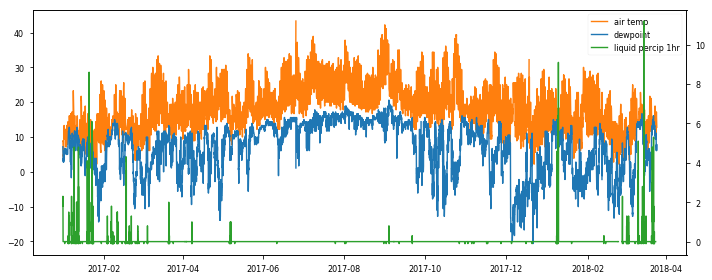

In [14]:
t = tempdf
fig = plt.figure(figsize=(10,4))
ax = fig.add_subplot(1,1,1)
ax2 = ax.twinx()
ax.plot(t.index, t['air temp'], c='C1')#, marker='x', mew=1)
ax.plot(t.index, t['dewpoint'], c='C0')#, marker='+', mew=1)
ax2.plot(t.index, t['liquid percip 1hr'], 'C2')

h1,l1 = ax.get_legend_handles_labels()
h2,l2 = ax2.get_legend_handles_labels()
ax.legend(h1+h2, l1+l2)
fig.tight_layout()
# clear_output(wait=True)
# fig.show()

### Trim to just the dates we want

In [15]:
fulldf = tempdf.copy(deep=True)
if END_DATE is None:
    tempdf = tempdf[START_DATE:]
else:
    tempdf = tempdf[START_DATE:END_DATE]
tempdf.index.name = 'datetime'

### Cleanup data a bit (remove spurious temps and dewpoints at least)
@TCC More cleanup is probably in order here... Must at least check carefully

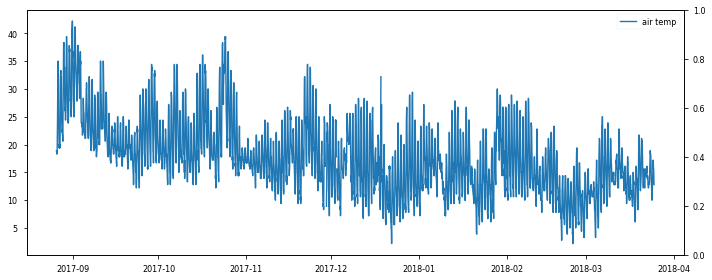

In [16]:
t = tempdf
fig = plt.figure(figsize=(10,4))
ax = fig.add_subplot(1,1,1)
ax2 = ax.twinx()
ax.plot(t.index, t['air temp'])#, marker='x', mew=1)
# ax.plot(t.index, t['dewpoint'])#, marker='+', mew=1)
# ax2.plot(t.index, t['liquid percip 1hr'], 'C2')

h1,l1 = ax.get_legend_handles_labels()
h2,l2 = ax2.get_legend_handles_labels()
ax.legend(h1+h2, l1+l2)
fig.tight_layout()

### Resample (possibly upsample and interpolate)

In [17]:
RESAMP_FREQ = '15min'
INTERP_METHOD = 'pchip'
t = tempdf.copy(deep=True)
t = t.resample(RESAMP_FREQ).interpolate(method=INTERP_METHOD)
tempdf = t

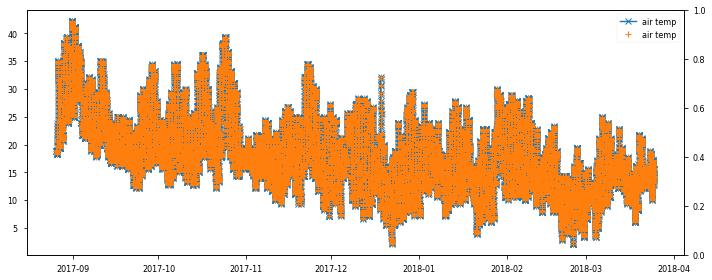

In [18]:
fig = plt.figure(figsize=(10,4))
ax = fig.add_subplot(1,1,1)
ax2 = ax.twinx()
ax.plot(t.index, t['air temp'], marker='x', mew=1)
ax.plot(tempdf.index, tempdf['air temp'], ls='none', marker='+', mew=1, mfc='none')
# ax.plot(t.index, t['dewpoint'])#, marker='+', mew=1)
# ax2.plot(t.index, t['liquid percip 1hr'], 'C2')

h1,l1 = ax.get_legend_handles_labels()
h2,l2 = ax2.get_legend_handles_labels()
ax.legend(h1+h2, l1+l2)
fig.tight_layout()

In [19]:
# investigating the temperature diff/step sizes
t['air temp'].diff().describe()

count    20244.000000
mean        -0.000301
std          0.384046
min         -3.784349
25%         -0.206250
50%          0.000000
75%          0.171875
max          2.798780
Name: air temp, dtype: float64

In [20]:
t.loc[t['air temp'].diff().idxmax()]

year                                 2017.000000
month                                  11.000000
day                                    29.000000
hour                                   17.750000
air temp                               18.214018
dewpoint                                8.670597
sea level pressure                   1016.160530
wind direction                          0.000000
wind speed                              0.000000
sky condition total coverage code       0.000000
liquid percip 1hr                       0.000000
liquid percip 6hr                      -0.100000
Name: 2017-11-29 09:45:00-08:00, dtype: float64

### Add VPD and RH columns

In [21]:
es = temp2vp(tempdf['air temp'])
e = temp2vp(tempdf['dewpoint'])
tempdf['RH'] = 100*e/es
tempdf['VPD'] = (es - e)/1000.0 # in Kpa
tempdf

,year,month,day,hour,air temp,dewpoint,sea level pressure,wind direction,wind speed,sky condition total coverage code,liquid percip 1hr,liquid percip 6hr,RH,VPD
datetime,,,,,,,,,,,,,,
2017-08-26 00:00:00-08:00,2017.0,8.0,26.000000,8.000000,18.900000,16.100000,1010.700000,190.000000,1.500000,0.0,0.0,NaN,83.789420,0.354123
2017-08-26 00:15:00-08:00,2017.0,8.0,26.000000,8.250000,18.900000,16.100000,1010.700000,120.234375,0.949219,0.0,0.0,NaN,83.789420,0.354123
2017-08-26 00:30:00-08:00,2017.0,8.0,26.000000,8.500000,18.900000,16.100000,1010.700000,59.375000,0.468750,0.0,0.0,NaN,83.789420,0.354123
2017-08-26 00:45:00-08:00,2017.0,8.0,26.000000,8.750000,18.900000,16.100000,1010.700000,16.328125,0.128906,0.0,0.0,NaN,83.789420,0.354123
2017-08-26 01:00:00-08:00,2017.0,8.0,26.000000,9.000000,18.900000,16.100000,1010.700000,0.000000,0.000000,0.0,0.0,NaN,83.789420,0.354123
2017-08-26 01:15:00-08:00,2017.0,8.0,26.000000,9.250000,18.900000,16.100000,1010.691406,0.000000,0.000000,0.0,0.0,NaN,83.789420,0.354123
2017-08-26 01:30:00-08:00,2017.0,8.0,26.000000,9.500000,18.900000,16.100000,1010.668750,0.000000,0.000000,0.0,0.0,NaN,83.789420,0.354123
2017-08-26 01:45:00-08:00,2017.0,8.0,26.000000,9.750000,18.900000,16.100000,1010.636719,0.000000,0.000000,0.0,0.0,NaN,83.789420,0.354123
2017-08-26 02:00:00-08:00,2017.0,8.0,26.000000,10.000000,18.900000,16.100000,1010.600000,0.000000,0.000000,0.0,0.0,NaN,83.789420,0.354123


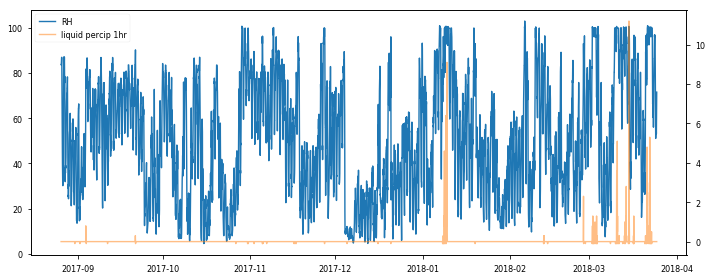

In [22]:
t = tempdf
fig = plt.figure(figsize=(10,4))
ax = fig.add_subplot(1,1,1)
ax2 = ax.twinx()
ax.plot(t.index, t['RH'], c='C0')
# ax2.plot(t.index, t['VPD'], c='C1', alpha=0.5)
ax2.plot(t.index, t['liquid percip 1hr'], 'C1', alpha=0.5)

h1,l1 = ax.get_legend_handles_labels()
h2,l2 = ax2.get_legend_handles_labels()
ax.legend(h1+h2, l1+l2)
fig.tight_layout()

### Add column for sun angle [@TCC not using for now, but could]
For now just treated as <=thresh is off, >thresh is on, may implement as light level eventually
-6 degrees (civil twilight) is probably a good threshold

In [23]:
# need lat and lon
station_info = get_ISD_history_file(DATADIR, NOAA_ISD_ftp_host)
station_info = station_info.loc[(station_info['USAF'].astype(str) + station_info['WBAN'].astype(str)).isin([ str(x)+str(y) for x,y in ISD_STATION_IDS ])]

# ephem uses a body and observer object, so make those
sun = ephem.Sun()
obs = ephem.Observer()
obs.lat = station_info['LAT'].astype(float).mean()
obs.lon = station_info['LON'].astype(float).mean()
obs.elevation = station_info['EVEV'].astype(float).mean()

def datetime2sunalt(d): # function to apply
    obs.date = ephem.Date(str(d))
    sun.compute(obs)
    return sun.alt*180/np.pi

tempdf['sun angle'] = -1*pd.Series(tempdf.index, index=tempdf.index).apply(datetime2sunalt)
tempdf

,year,month,day,hour,air temp,dewpoint,sea level pressure,wind direction,wind speed,sky condition total coverage code,liquid percip 1hr,liquid percip 6hr,RH,VPD,sun angle
datetime,,,,,,,,,,,,,,,
2017-08-26 00:00:00-08:00,2017.0,8.0,26.000000,8.000000,18.900000,16.100000,1010.700000,190.000000,1.500000,0.0,0.0,NaN,83.789420,0.354123,-33.243555
2017-08-26 00:15:00-08:00,2017.0,8.0,26.000000,8.250000,18.900000,16.100000,1010.700000,120.234375,0.949219,0.0,0.0,NaN,83.789420,0.354123,-36.755010
2017-08-26 00:30:00-08:00,2017.0,8.0,26.000000,8.500000,18.900000,16.100000,1010.700000,59.375000,0.468750,0.0,0.0,NaN,83.789420,0.354123,-40.263682
2017-08-26 00:45:00-08:00,2017.0,8.0,26.000000,8.750000,18.900000,16.100000,1010.700000,16.328125,0.128906,0.0,0.0,NaN,83.789420,0.354123,-43.766940
2017-08-26 01:00:00-08:00,2017.0,8.0,26.000000,9.000000,18.900000,16.100000,1010.700000,0.000000,0.000000,0.0,0.0,NaN,83.789420,0.354123,-47.261603
2017-08-26 01:15:00-08:00,2017.0,8.0,26.000000,9.250000,18.900000,16.100000,1010.691406,0.000000,0.000000,0.0,0.0,NaN,83.789420,0.354123,-50.743630
2017-08-26 01:30:00-08:00,2017.0,8.0,26.000000,9.500000,18.900000,16.100000,1010.668750,0.000000,0.000000,0.0,0.0,NaN,83.789420,0.354123,-54.207673
2017-08-26 01:45:00-08:00,2017.0,8.0,26.000000,9.750000,18.900000,16.100000,1010.636719,0.000000,0.000000,0.0,0.0,NaN,83.789420,0.354123,-57.646380
2017-08-26 02:00:00-08:00,2017.0,8.0,26.000000,10.000000,18.900000,16.100000,1010.600000,0.000000,0.000000,0.0,0.0,NaN,83.789420,0.354123,-61.049201


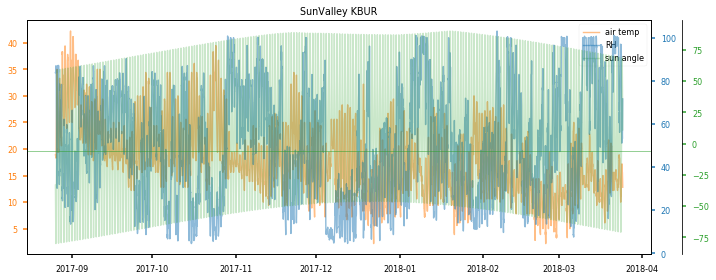

In [24]:
t = tempdf
fig = plt.figure(figsize=(10,4))
ax = fig.add_subplot(1,1,1)
ax2 = ax.twinx()
ax3 = ax.twinx()
p1, = ax.plot(t.index, t['air temp'], c='C1', alpha=0.5)
p2, = ax2.plot(t.index, t['RH'], c='C0', alpha=0.5)
p3, = ax3.plot(t.index, t['sun angle'], 'C2', alpha=0.25)
ax3.axhline(-6, ls='-', lw=.5, c='C2')

ax3.spines["right"].set_position(("axes", 1.05))

ax.yaxis.label.set_color(p1.get_color())
ax2.yaxis.label.set_color(p2.get_color())
ax3.yaxis.label.set_color(p3.get_color())
tkw = dict(size=4, width=1.5)
ax.tick_params(axis='y', colors=p1.get_color(), **tkw)
ax2.tick_params(axis='y', colors=p2.get_color(), **tkw)
ax3.tick_params(axis='y', colors=p3.get_color(), **tkw)
ax.tick_params(axis='x', **tkw)

ax.set_title(SITENAME+" "+CALLSIGN)
h1,l1 = ax.get_legend_handles_labels()
h2,l2 = ax2.get_legend_handles_labels()
h3,l3 = ax3.get_legend_handles_labels()
ax.legend(h1+h2+h3, l1+l2+l3)
fig.tight_layout()

### Summary figure

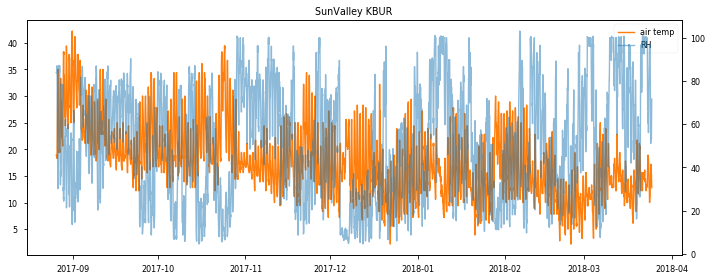

In [25]:
t = tempdf
fig = plt.figure(figsize=(10,4))
ax = fig.add_subplot(1,1,1)
ax2 = ax.twinx()
ax2.plot(t.index, t['RH'], c='C0', alpha=0.5)
ax.plot(t.index, t['air temp'], c='C1')

ax.set_title(SITENAME+" "+CALLSIGN)
h1,l1 = ax.get_legend_handles_labels()
h2,l2 = ax2.get_legend_handles_labels()
ax.legend(h1+h2, l1+l2)
fig.tight_layout()

### Prepare reduced output dataframe

In [26]:
out = tempdf[['air temp', 'RH']].copy(deep=True)

### Simple light cycle

In [27]:
# 6:00 to 18:00 light cycle
out['light'] = 0
out.loc[(out.index.hour>=6) & (out.index.hour<18), 'light'] = 1

### Constant Humidity

In [28]:
# 6:00 to 18:00 light cycle
out['RH'] = 80

In [29]:
out

,air temp,RH,light
datetime,,,
2017-08-26 00:00:00-08:00,18.900000,80,0
2017-08-26 00:15:00-08:00,18.900000,80,0
2017-08-26 00:30:00-08:00,18.900000,80,0
2017-08-26 00:45:00-08:00,18.900000,80,0
2017-08-26 01:00:00-08:00,18.900000,80,0
2017-08-26 01:15:00-08:00,18.900000,80,0
2017-08-26 01:30:00-08:00,18.900000,80,0
2017-08-26 01:45:00-08:00,18.900000,80,0
2017-08-26 02:00:00-08:00,18.900000,80,0


### Save

In [30]:
# # station info for the save file
# station_info = get_ISD_history_file(DATADIR, NOAA_ISD_ftp_host)
# station_info = station_info.loc[(station_info['USAF'].astype(str) + station_info['WBAN'].astype(str)).isin([ str(x)+str(y) for x,y in ISD_STATION_IDS ])]
# display(station_info)

In [31]:
out.to_csv(SITENAME+'.csv')